# Using commuting projectors in STRUPHY

In STRUPHY the commuting projectors of the de Rham sequence are based on __inter-/histopolation__ of spline basis functions at Greville points. 

There are two kinds of projectors in STRUPHY:

* __global projectors__ based on inter-/histopolation in the __whole domain__ 
* __local projectors__ based on quasi-inter-/histopolation in a __neighbourhood of $x_i$__

In [1]:
import numpy             as np
import matplotlib.pyplot as plt

import hylife.utilitis_FEEC.projectors_global as proj_glob
import hylife.utilitis_FEEC.evaluation as eva

import hylife.utilitis_FEEC.bsplines as bsp

## Global projectors in 1D

Nel= 8
Nq= 6  0.0606482  0.0000000  |   0.0350961  0.0000000  |   0.0293687  0.0000000  | 
Nel= 16
Nq= 6  0.0215515  2.8141068  |   0.0105696  3.3204750  |   0.0081061  3.6230371  | 
Nel= 32
Nq= 6  0.0021679  9.9413679  |   0.0007974 13.2544025  |   0.0005994 13.5238667  | 
Nel= 64
Nq= 6  0.0002560  8.4686220  |   0.0000857  9.3034906  |   0.0000633  9.4714750  | 
Nel= 128
Nq= 6  0.0000315  8.1300119  |   0.0000103  8.3247363  |   0.0000075  8.3950422  | 
Nel= 256
Nq= 6  0.0000039  8.0331727  |   0.0000013  8.0812038  |   0.0000009  8.0994734  | 
Nel= 512
Nq= 6  0.0000005  8.0083332  |   0.0000002  8.0203039  |   0.0000001  8.0251567  | 


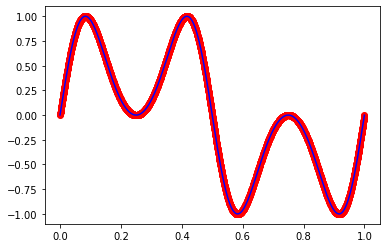

In [8]:
# ------------------------
# function to be projected
# ------------------------
fun = lambda xi1 : np.sin( np.pi*( np.sin(2.*np.pi*xi1) ) )

#-----------------
# Create the grid:
#-----------------
# side lengths of logical cube
L = 1.

# spline degree
p = 3   

# periodic boundary conditions (use 'False' if clamped)
bc = True

# errors:
before_max = 0.
before_L2  = 0.
before_L1  = 0.

# loop over different number of elements (convergence test)
Nel_cases = [8, 16, 32, 64, 128, 256, 512]

# loop over different number of quadrature points per element
Nq_cases = [6]

for Nel in Nel_cases:
    
    print('Nel=', Nel)
    
    # element boundaries
    el_b = np.linspace(0., L, Nel + 1) 

    # knot sequences
    T = bsp.make_knots(el_b, p, bc)
    
    for Nq in Nq_cases:

        # create an instance of the projector class
        obj = proj_glob.projectors_1d(T, p, bc, Nq)

        # compute coefficients
        #coeffs = obj.PI_0(fun)
        coeffs = obj.PI_1(fun)

        # grid points for error computation
        pts_loc, wts_loc = np.polynomial.legendre.leggauss(6)   

        pts, wts = bsp.quadrature_grid(el_b, pts_loc, wts_loc)    

        xgrid = pts.flatten()   # error grid

        # projection evaluated at the grid points
        f_h = eva.FEM_field_1d(coeffs, 1, xgrid, T, p, bc)

        # function evaluated at the grid points
        f   = fun( xgrid )

        # max-norm
        err_max = np.max( np.abs(f - f_h) )

        # L2-norm
        err_L2 = np.sqrt( np.sum( np.abs(f - f_h)**2 ) / np.size(f) )

        # L1-norm
        err_L1 = np.sum( np.abs(f - f_h) ) / np.size(f) 

        # print errors
        print( 'Nq=', Nq, 
               '{:10.7f}'.format(err_max), '{:10.7f}'.format(before_max/err_max), ' | ',
               '{:10.7f}'.format(err_L2),  '{:10.7f}'.format(before_L2/err_L2),   ' | ', 
               '{:10.7f}'.format(err_L1),  '{:10.7f}'.format(before_L1/err_L1),   ' | ')

        before_max = err_max
        before_L2  = err_L2
        before_L1  = err_L1
        
    #print('')
    
    
plt.plot(xgrid, f_h, 'ro', xgrid, f, 'b-')

## Global projectors in 3D 

In [3]:
# ------------------------
# function to be projected
# ------------------------
fun = lambda xi1, xi2, xi3 : np.sin( np.pi*( np.sin(2.*np.pi*xi1)
                                            *np.sin(2.*np.pi*xi2)
                                            *np.sin(2.*np.pi*xi3) ) )

#-----------------
# Create the grid:
#-----------------
# side lengths of logical cube
L = [1., 1., 1.] 

# spline degrees
p = [3, 2, 2]   

# periodic boundary conditions (use 'False' if clamped)
bc = [True, False, True] 

# errors:
before_max = 0.
before_L2  = 0.
before_L1  = 0.

# loop over different number of elements (convergence test)
Nel_cases = [16]

# loop over different number of quadrature points per element
Nq_cases = [1, 2, 3, 4, 5, 6, 7, 8]

for Nel in Nel_cases:
    
    print('Nel=', Nel)
    
    # number of elements
    Nel = [Nel, Nel, Nel]   

    # element boundaries
    el_b = [np.linspace(0., L, Nel + 1) for L, Nel in zip(L, Nel)] 

    # knot sequences
    T = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)] 
    
    for Nq in Nq_cases:
        
        # number of elements
        Nq = [Nq, Nq, Nq]

        # create an instance of the projector class
        obj = proj_glob.projectors_3d(T, p, bc, Nq)

        # ---------------------------------------------
        # create LU decomposition of necessary matrices
        # ---------------------------------------------
        #obj.NNN_LU()   # for PI_0
        #obj.DNN_LU()  # for PI_11
        #obj.NDN_LU()  # for PI_12
        obj.NND_LU()  # for PI_13
        #obj.NDD_LU()  # for PI_21
        #obj.DND_LU()  # for PI_22
        #obj.DDN_LU()  # for PI_23
        #obj.DDD_LU()  # for PI_3

        # --------------------
        # compute coefficients
        # --------------------
        #coeffs = obj.PI_0(fun)
        #coeffs = obj.PI_11(fun)
        #coeffs = obj.PI_12(fun)
        coeffs = obj.PI_13(fun)
        #coeffs = obj.PI_21(fun)
        #coeffs = obj.PI_22(fun)
        #coeffs = obj.PI_23(fun)
        #coeffs = obj.PI_3(fun)

        # grid points for error computation
        pts_loc, wts_loc = np.polynomial.legendre.leggauss(5)   # quadrature points per element

        pts1, wts1 = bsp.quadrature_grid(el_b[0], pts_loc, wts_loc)   
        pts2, wts2 = bsp.quadrature_grid(el_b[1], pts_loc, wts_loc) 
        pts3, wts3 = bsp.quadrature_grid(el_b[2], pts_loc, wts_loc) 

        xgrid = [ pts1.flatten(), pts2.flatten(), pts3.flatten() ]   # error grid

        # projection evaluated at the grid points
        f_h = eva.FEM_field_3d(coeffs, 13, xgrid, T, p, bc)

        # function evaluated at the grid points
        xi1, xi2, xi3 = np.meshgrid( xgrid[0], xgrid[1], xgrid[2], indexing='ij' )
        f   = fun( xi1, xi2, xi3 )

        # max-norm
        err_max = np.max( np.abs(f - f_h) )

        # L2-norm
        err_L2 = np.sqrt( np.sum( np.abs(f - f_h)**2 ) / np.size(f) )

        # L1-norm
        err_L1 = np.sum( np.abs(f - f_h) ) / np.size(f) 

        # print errors
        print( 'Nq=', Nq,
               '{:10.7f}'.format(err_max), '{:10.7f}'.format(before_max/err_max), ' | ',
               '{:10.7f}'.format(err_L2),  '{:10.7f}'.format(before_L2/err_L2),   ' | ', 
               '{:10.7f}'.format(err_L1),  '{:10.7f}'.format(before_L1/err_L1),   ' | ')

        before_max = err_max
        before_L2  = err_L2
        before_L1  = err_L1
        
    print('')

Nel= 16
Nq= [1, 1, 1]  0.1411205  0.0000000  |   0.0199445  0.0000000  |   0.0104854  0.0000000  | 
Nq= [2, 2, 2]  0.0763050  1.8494271  |   0.0138005  1.4452065  |   0.0084597  1.2394586  | 
Nq= [3, 3, 3]  0.0771149  0.9894976  |   0.0138203  0.9985637  |   0.0084529  1.0008030  | 
Nq= [4, 4, 4]  0.0771095  1.0000691  |   0.0138202  1.0000059  |   0.0084529  0.9999934  | 
Nq= [5, 5, 5]  0.0771096  0.9999997  |   0.0138202  1.0000000  |   0.0084529  1.0000000  | 
Nq= [6, 6, 6]  0.0771096  1.0000000  |   0.0138202  1.0000000  |   0.0084529  1.0000000  | 
Nq= [7, 7, 7]  0.0771096  1.0000000  |   0.0138202  1.0000000  |   0.0084529  1.0000000  | 
Nq= [8, 8, 8]  0.0771096  1.0000000  |   0.0138202  1.0000000  |   0.0084529  1.0000000  | 

